# Importing Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from scipy.stats import stats
import missingno as msno
import string
import re
import nltk
from nltk import FreqDist
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from textblob import  TextBlob, Word
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models.word2vec import  Word2Vec

In [ ]:
plt.rc('font', size=15)
plt.style.use('dark_background')

# Importing the Input Dataset

In [ ]:
data_job_posts = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/6. Analyzing online Job Postings/data job posts.csv')

# Data Inspection and Cleaning

In [ ]:
data_job_posts.head()

,jobpost,date,Title,Company,AnnouncementCode,Term,Eligibility,Audience,StartDate,Duration,Location,JobDescription,JobRequirment,RequiredQual,Salary,ApplicationP,OpeningDate,Deadline,Notes,AboutC,Attach,Year,Month,IT
0,AMERIA Investment Consulting Company\nJOB TITL...,"Jan 5, 2004",Chief Financial Officer,AMERIA Investment Consulting Company,NaN,NaN,NaN,NaN,NaN,NaN,"Yerevan, Armenia",AMERIA Investment Consulting Company is seekin...,- Supervises financial management and administ...,"To perform this job successfully, an\nindividu...",NaN,"To apply for this position, please submit a\nc...",NaN,26 January 2004,NaN,NaN,NaN,2004,1,False
1,International Research & Exchanges Board (IREX...,"Jan 7, 2004",Full-time Community Connections Intern (paid i...,International Research & Exchanges Board (IREX),NaN,NaN,NaN,NaN,NaN,3 months,"IREX Armenia Main Office; Yerevan, Armenia \nD...",NaN,NaN,- Bachelor's Degree; Master's is preferred;\n-...,NaN,Please submit a cover letter and resume to:\nI...,NaN,12 January 2004,NaN,The International Research & Exchanges Board (...,NaN,2004,1,False
2,Caucasus Environmental NGO Network (CENN)\nJOB...,"Jan 7, 2004",Country Coordinator,Caucasus Environmental NGO Network (CENN),NaN,NaN,NaN,NaN,NaN,Renewable annual contract\nPOSITION,"Yerevan, Armenia",Public outreach and strengthening of a growing...,- Working with the Country Director to provide...,"- Degree in environmentally related field, or ...",NaN,Please send resume or CV toursula.kazarian@......,NaN,20 January 2004\nSTART DATE: February 2004,NaN,The Caucasus Environmental NGO Network is a\nn...,NaN,2004,1,False
3,Manoff Group\nJOB TITLE: BCC Specialist\nPOSI...,"Jan 7, 2004",BCC Specialist,Manoff Group,NaN,NaN,NaN,NaN,NaN,NaN,"Manila, Philippines",The LEAD (Local Enhancement and Development fo...,- Identify gaps in knowledge and overseeing in...,"- Advanced degree in public health, social sci...",NaN,Please send cover letter and resume to Amy\nPe...,NaN,23 January 2004\nSTART DATE: Immediate,NaN,NaN,NaN,2004,1,False
4,Yerevan Brandy Company\nJOB TITLE: Software D...,"Jan 10, 2004",Software Developer,Yerevan Brandy Company,NaN,NaN,NaN,NaN,NaN,NaN,"Yerevan, Armenia",NaN,- Rendering technical assistance to Database M...,- University degree; economical background is ...,NaN,Successful candidates should submit\n- CV; \n-...,NaN,"20 January 2004, 18:00",NaN,NaN,NaN,2004,1,True


In [ ]:
data_job_posts.shape

(19001, 24)

In [ ]:
data_job_posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19001 entries, 0 to 19000
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   jobpost           19001 non-null  object
 1   date              19001 non-null  object
 2   Title             18973 non-null  object
 3   Company           18994 non-null  object
 4   AnnouncementCode  1208 non-null   object
 5   Term              7676 non-null   object
 6   Eligibility       4930 non-null   object
 7   Audience          640 non-null    object
 8   StartDate         9675 non-null   object
 9   Duration          10798 non-null  object
 10  Location          18969 non-null  object
 11  JobDescription    15109 non-null  object
 12  JobRequirment     16479 non-null  object
 13  RequiredQual      18517 non-null  object
 14  Salary            9622 non-null   object
 15  ApplicationP      18941 non-null  object
 16  OpeningDate       18295 non-null  object
 17  Deadline    

## Duplicate value Inspection

In [ ]:
data_job_posts.duplicated().sum()

39

#### Dropping the Duplicated Observations

In [ ]:
data_job_posts.drop_duplicates(inplace=True, ignore_index=True)

## Missing Values Inspection

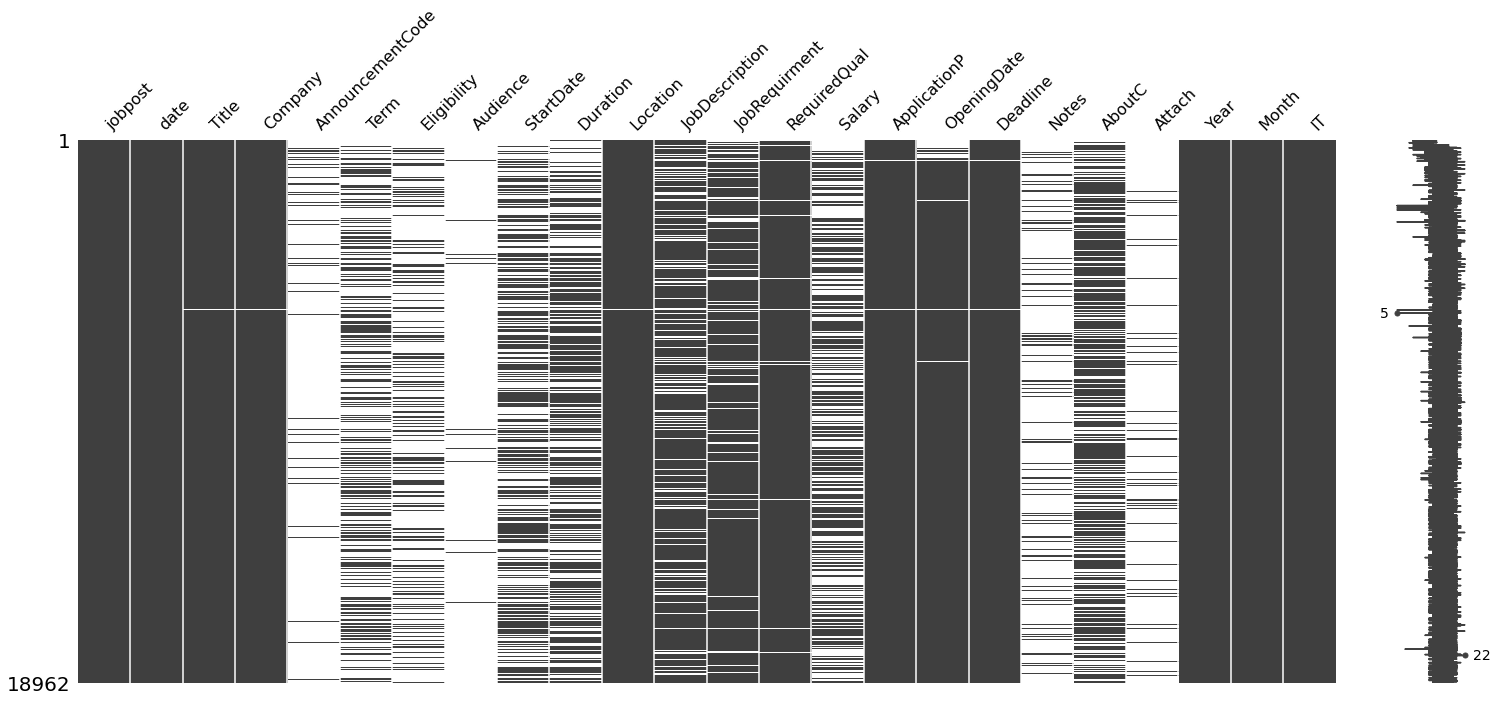

In [ ]:
msno.matrix(data_job_posts)

In [ ]:
data_job_posts.isna().sum()/data_job_posts.shape[0]*100

jobpost              0.000000
date                 0.000000
Title                0.147664
Company              0.036916
AnnouncementCode    93.639911
Term                59.582323
Eligibility         74.063917
Audience            96.635376
StartDate           49.092923
Duration            43.175825
Location             0.168759
JobDescription      20.493619
JobRequirment       13.252821
RequiredQual         2.536652
Salary              49.351334
ApplicationP         0.316422
OpeningDate          3.712689
Deadline             0.342791
Notes               88.376754
AboutC              34.400380
Attach              91.794115
Year                 0.000000
Month                0.000000
IT                   0.000000
dtype: float64

We can see that there are so many variables with high proportion of missing values. So we are going to drop variables with more than 20% of missing values which are also not much significant to the Business Problem.

In [ ]:
list_drop = ['AnnouncementCode', 'Term', 'Eligibility', 'Audience', 'StartDate', 'Duration', 'Salary', 'Notes', 'Attach']

In [ ]:
data_job_posts.drop(columns=list_drop, inplace=True)

In [ ]:
data_job_posts.head()

,jobpost,date,Title,Company,Location,JobDescription,JobRequirment,RequiredQual,ApplicationP,OpeningDate,Deadline,AboutC,Year,Month,IT
0,AMERIA Investment Consulting Company\nJOB TITL...,"Jan 5, 2004",Chief Financial Officer,AMERIA Investment Consulting Company,"Yerevan, Armenia",AMERIA Investment Consulting Company is seekin...,- Supervises financial management and administ...,"To perform this job successfully, an\nindividu...","To apply for this position, please submit a\nc...",NaN,26 January 2004,NaN,2004,1,False
1,International Research & Exchanges Board (IREX...,"Jan 7, 2004",Full-time Community Connections Intern (paid i...,International Research & Exchanges Board (IREX),"IREX Armenia Main Office; Yerevan, Armenia \nD...",NaN,NaN,- Bachelor's Degree; Master's is preferred;\n-...,Please submit a cover letter and resume to:\nI...,NaN,12 January 2004,The International Research & Exchanges Board (...,2004,1,False
2,Caucasus Environmental NGO Network (CENN)\nJOB...,"Jan 7, 2004",Country Coordinator,Caucasus Environmental NGO Network (CENN),"Yerevan, Armenia",Public outreach and strengthening of a growing...,- Working with the Country Director to provide...,"- Degree in environmentally related field, or ...",Please send resume or CV toursula.kazarian@......,NaN,20 January 2004\nSTART DATE: February 2004,The Caucasus Environmental NGO Network is a\nn...,2004,1,False
3,Manoff Group\nJOB TITLE: BCC Specialist\nPOSI...,"Jan 7, 2004",BCC Specialist,Manoff Group,"Manila, Philippines",The LEAD (Local Enhancement and Development fo...,- Identify gaps in knowledge and overseeing in...,"- Advanced degree in public health, social sci...",Please send cover letter and resume to Amy\nPe...,NaN,23 January 2004\nSTART DATE: Immediate,NaN,2004,1,False
4,Yerevan Brandy Company\nJOB TITLE: Software D...,"Jan 10, 2004",Software Developer,Yerevan Brandy Company,"Yerevan, Armenia",NaN,- Rendering technical assistance to Database M...,- University degree; economical background is ...,Successful candidates should submit\n- CV; \n-...,NaN,"20 January 2004, 18:00",NaN,2004,1,True


#### Dropping the useless variables aswell which are not significant to the Business Problem.

In [ ]:
list_drop = ['date', 'ApplicationP', 'OpeningDate', 'Deadline']

In [ ]:
data_job_posts.drop(columns=list_drop, inplace=True)

In [ ]:
data_job_posts.shape[1]

11

In [ ]:
data_job_posts.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
Year,18962.0,2010.27,3.32,2004.0,2008.0,2011.0,2013.0,2015.0
Month,18962.0,6.49,3.41,1.0,3.0,7.0,9.0,12.0


# Exploratory Data Analysis about Job Nature

## Types of Jobs in Demand in Armenia

In [ ]:
print('There are currently %d types of Jobs given in the Data'%data_job_posts.Title.nunique())

There are currently 8636 types of Jobs given in the Data


In [ ]:
top_jobs_summ = data_job_posts[['Title', 'IT']].groupby('Title').agg({'IT':['count','max']}).reset_index()
top_jobs_summ.columns = ['Title', 'Count', 'IT']
top_jobs_summ = top_jobs_summ.sort_values(by='Count', ascending=False)[:10]
top_jobs_summ

,Title,Count,IT
134,Accountant,328,False
1179,Chief Accountant,219,False
4981,Medical Representative,216,False
6689,Sales Manager,166,False
229,Administrative Assistant,155,False
4322,Lawyer,151,False
7482,Software Developer,134,True
6037,Project Manager,117,False
2371,English Language Courses,109,False
8509,Web Developer,101,True


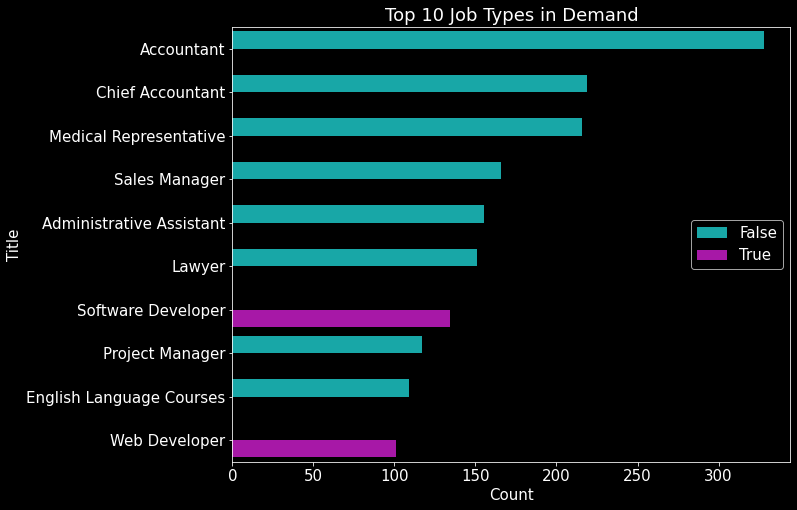

In [ ]:
with plt.style.context('dark_background'):
  plt.figure(figsize=(10,8))
  sns.barplot(data=top_jobs_summ, x='Count', y='Title', orient='h', hue='IT', palette=['c', 'm'])
  plt.xlabel('Count')
  plt.title('Top 10 Job Types in Demand')
  plt.legend(loc='right')
  plt.show()

Jobs related to accountancy topped the chart followed by the medical representative. Software developer and Web developer were able to make in Top 10 list which represents the weightage of IT industry increasing day by day.

## Change in Job Postings with Year

In [ ]:
job_nature_year = data_job_posts[['Year', 'IT']].groupby('Year').agg({'IT':['count','sum']}).reset_index()
job_nature_year.columns = ['Year', 'Count', 'IT']
job_nature_year['Non-IT'] = job_nature_year.Count - job_nature_year.IT
job_nature_year

,Year,Count,IT,Non-IT
0,2004,875,145,730
1,2005,1138,208,930
2,2006,1116,225,891
3,2007,1538,317,1221
4,2008,1785,334,1451
5,2009,1191,155,1036
6,2010,1511,224,1287
7,2011,1697,327,1370
8,2012,2149,473,1676
9,2013,2009,378,1631


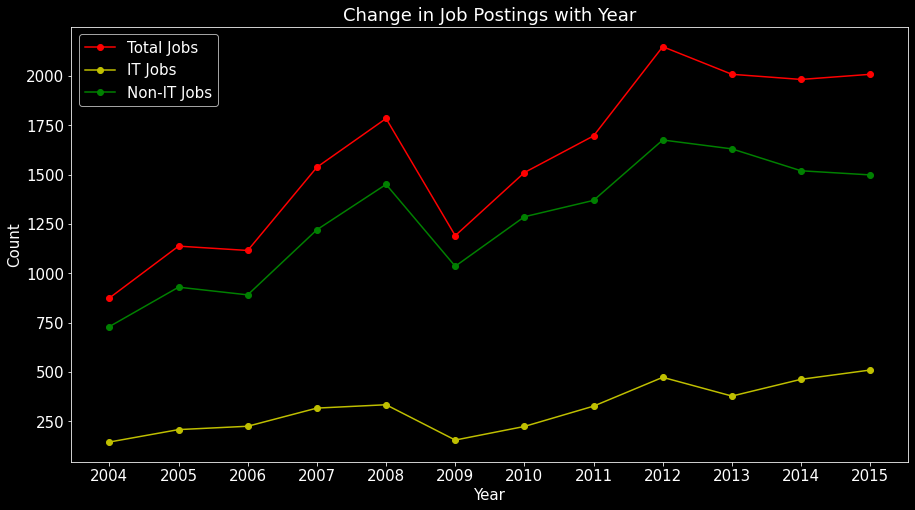

In [ ]:
with plt.style.context('dark_background'):
  plt.figure(figsize=(15,8))
  plt.plot(job_nature_year.Count, 'r-o', label='Total Jobs')
  plt.plot(job_nature_year.IT, 'y-o', label='IT Jobs')
  plt.plot(job_nature_year['Non-IT'], 'g-o', label='Non-IT Jobs')
  plt.xticks(np.arange(0,12), job_nature_year.Year)
  plt.xlabel('Year')
  plt.ylabel('Count')
  plt.title('Change in Job Postings with Year')
  plt.legend()
  plt.show()

Job Postings have almost doubled in the last decade for both categories but there is a dip in job postings which can be seen in the line chart for the year 2009 which might have caused by the Great Recession. The Great Recession was a period of marked general decline (recession) observed in national economies globally that occurred between 2007 and 2009.

## Change in Job Postings with Months

In [ ]:
temp_dict = {}
for year in data_job_posts.Year.unique():
  temp_dict[f'y_{year}'] = data_job_posts.loc[data_job_posts.Year==year].Month.value_counts().sort_index()
job_nature_month = pd.DataFrame(temp_dict, index=np.arange(1,13))
job_nature_month

,y_2004,y_2005,y_2006,y_2007,y_2008,y_2009,y_2010,y_2011,y_2012,y_2013,y_2014,y_2015
1,40,99,74,118,138,74,96,127,171,181,151,155
2,59,116,123,142,166,111,118,150,175,164,175,166
3,75,101,92,125,135,87,154,160,175,213,199,186
4,67,90,92,121,134,91,103,141,161,164,162,140
5,71,102,112,116,130,89,124,146,186,149,186,169
6,72,94,84,155,186,100,130,130,184,175,172,180
7,96,107,91,119,173,124,128,132,148,153,141,183
8,75,98,90,122,145,99,150,143,228,139,158,166
9,75,108,99,117,186,96,128,136,189,172,175,171
10,70,78,96,151,166,97,122,141,201,173,170,172


In [ ]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']

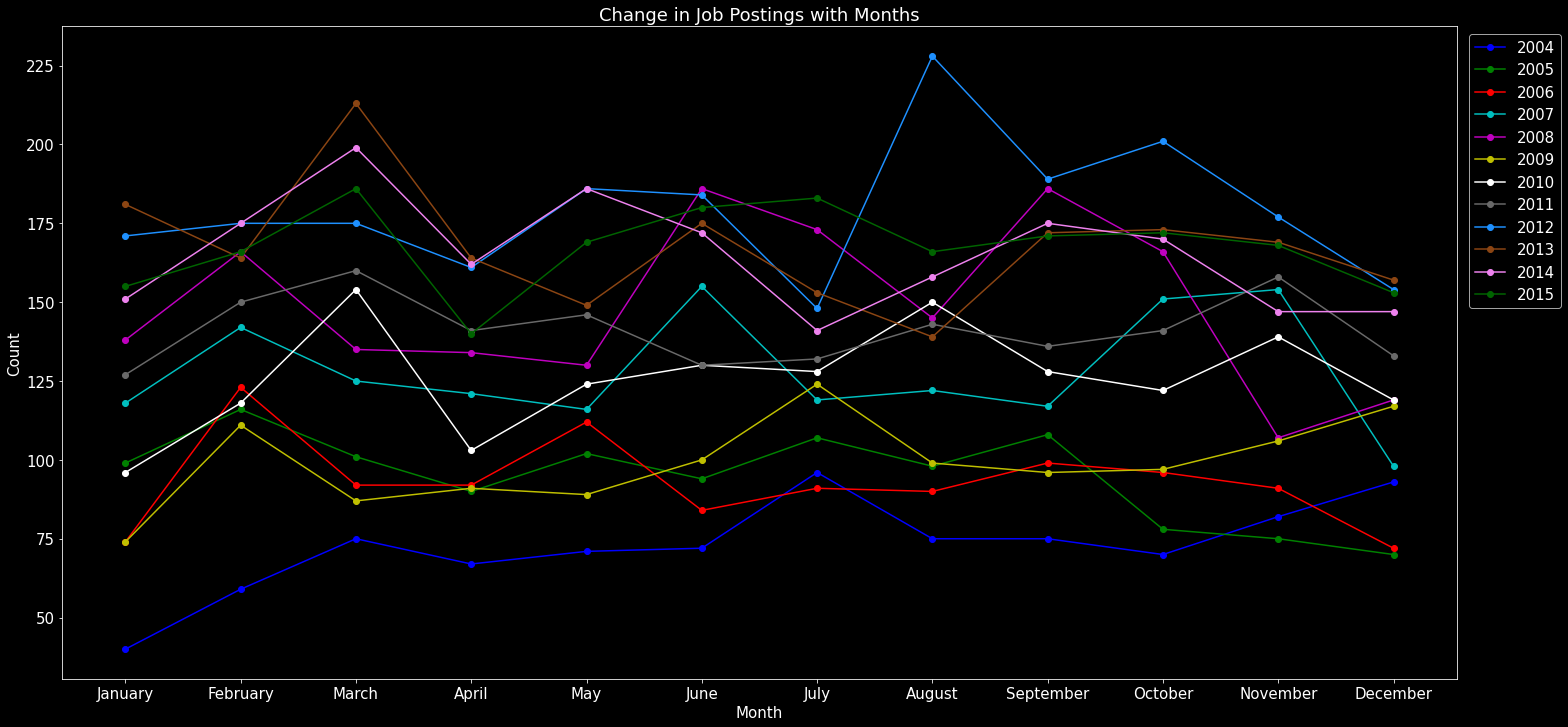

In [ ]:
with plt.style.context('dark_background'):
  plt.figure(figsize=(25,12))
  plt.plot(job_nature_month.y_2004, 'b-o', label='2004')
  plt.plot(job_nature_month.y_2005, 'g-o', label='2005')
  plt.plot(job_nature_month.y_2006, 'r-o', label='2006')
  plt.plot(job_nature_month.y_2007, 'c-o', label='2007')
  plt.plot(job_nature_month.y_2008, 'm-o', label='2008')
  plt.plot(job_nature_month.y_2009, 'y-o', label='2009')
  plt.plot(job_nature_month.y_2010, 'w-o', label='2010')
  plt.plot(job_nature_month.y_2011, 'dimgray', marker='o', label='2011')
  plt.plot(job_nature_month.y_2012, 'dodgerblue', marker='o', label='2012')
  plt.plot(job_nature_month.y_2013, 'saddlebrown', marker='o', label='2013')
  plt.plot(job_nature_month.y_2014, 'violet', marker='o', label='2014')
  plt.plot(job_nature_month.y_2015, 'darkgreen', marker='o', label='2015')
  plt.xticks(np.arange(1,13), months)
  plt.xlabel('Month')
  plt.ylabel('Count')
  plt.title('Change in Job Postings with Months')
  plt.legend(bbox_to_anchor=(1.08, 1))
  plt.show()

The Chart peeked for August of 2012 followed by March of 2013 and the least job postings were seen, as expected, in the January of 2004.

## Nature of Job Postings by Companies

In [ ]:
job_nature_company = data_job_posts[['Company', 'IT']].groupby('Company').agg({'IT':['count','sum']}).reset_index()
job_nature_company.columns = ['Company', 'Count', 'IT']
job_nature_company = job_nature_company.sort_values(by='Count', ascending=False)[:10]
job_nature_company

,Company,Count,IT
1125,ArmenTel CJSC,353,20
4458,World Vision Armenia,239,0
3063,Mentor Graphics Development Services CJSC,236,151
1556,Career Center NGO,229,1
3335,Orange Armenia,203,17
970,Ameriabank CJSC,196,22
1756,Converse Bank CJSC,161,18
3650,SAS Group LLC,150,17
4184,UNDP Armenia Office,132,11
1655,Central Bank of Armenia,126,17


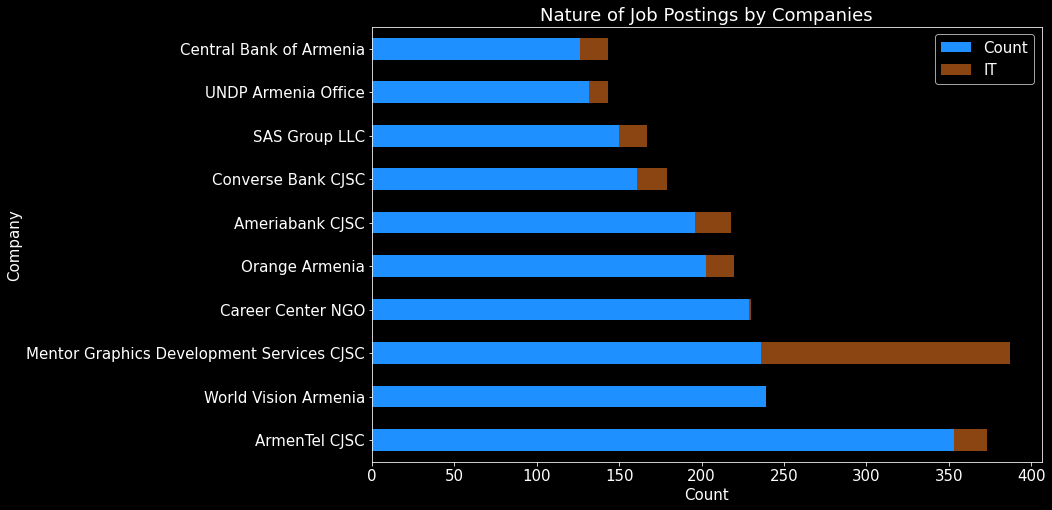

In [ ]:
with plt.style.context('dark_background'):
  job_nature_company.set_index('Company').plot(kind='barh', stacked=True, color=['dodgerblue', 'saddlebrown'], figsize=(12,8))
  plt.xlabel('Count')
  plt.title('Nature of Job Postings by Companies')
  plt.show()

ArmenTel CJSC showed the Highest Count for Job Postings but they still had much lower proportions for IT Jobs than Non-IT jobs Whereas World Vision Armenia had 0 job postings for IT-Jobs even being at 2nd number for overall Job Postings followed by the 3rd placed company i.e. Mentor Graphics Development Services CJSC had more amount of IT Jobs Postings than Non-IT Jobs just as their company name gave it away.

# Data Pre-Processing before Modelling

## Missing Values Treatment

In [ ]:
data_job_posts.isna().sum()

jobpost              0
Title               28
Company              7
Location            32
JobDescription    3886
JobRequirment     2513
RequiredQual       481
AboutC            6523
Year                 0
Month                0
IT                   0
dtype: int64

We are going to drop the observations where there are missing values in 'Title' and 'RequiredQual' because we don't want to alter the information in these variables as they are most important.

In [ ]:
data_job_posts = data_job_posts.drop(index=data_job_posts[data_job_posts.Title.isna()].index).reset_index(drop=True)

In [ ]:
data_job_posts = data_job_posts.drop(index=data_job_posts[data_job_posts.RequiredQual.isna()].index).reset_index(drop=True)

In [ ]:
data_job_posts.isna().sum()

jobpost              0
Title                0
Company              0
Location            12
JobDescription    3412
JobRequirment     2035
RequiredQual         0
AboutC            6386
Year                 0
Month                0
IT                   0
dtype: int64

Now, We are going to impute the missing values of 'JobDescription' and 'JobRequirment' based on their respective job 'Title'. Similarly, We are going to impute the missing values of 'Location' and 'AboutC' based on their respective 'Company'.
This is a much more sophisticated approach of handling missing values than just imputing them with the mode of whole general data, which would have altered with the information.

In [ ]:
final_data = data_job_posts.copy()
for col in ['JobDescription', 'JobRequirment']:
  for i in final_data.index:
    if pd.isna(final_data.loc[i,col]):
      temp_mode = stats.mode(final_data.loc[final_data.Title==final_data.loc[i,'Title'], col])[0][0]
      if temp_mode != 0:
        final_data.loc[i,col] = temp_mode
for col in ['Location', 'AboutC']:
  for i in final_data.index:
    if pd.isna(final_data.loc[i,col]):
      temp_mode = stats.mode(final_data.loc[final_data.Company==final_data.loc[i,'Company'], col])[0][0]
      if temp_mode != 0:
        final_data.loc[i,col] = temp_mode
final_data.isna().sum()

jobpost              0
Title                0
Company              0
Location             8
JobDescription    1761
JobRequirment      993
RequiredQual         0
AboutC            2695
Year                 0
Month                0
IT                   0
dtype: int64

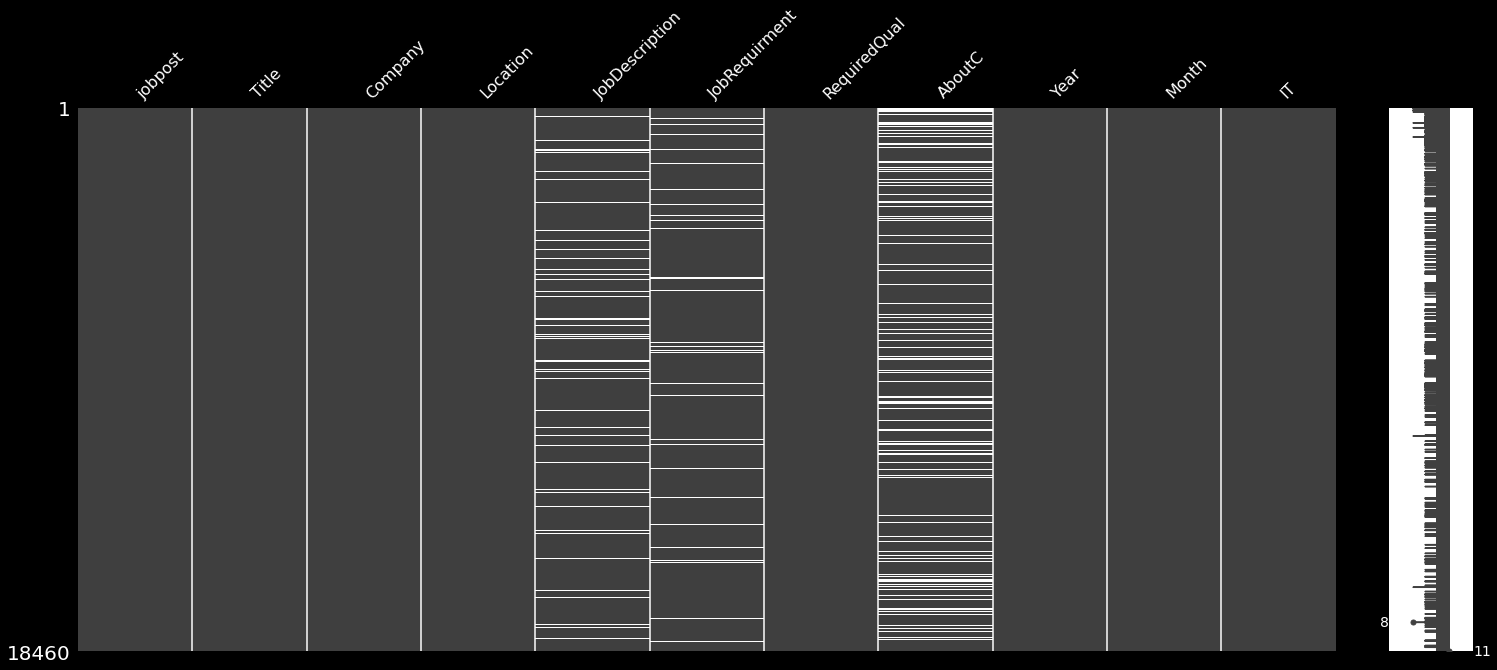

In [ ]:
msno.matrix(final_data)

We were able to impute most of the missing values in each variable.

## Encoding the Dependent Variable

### For Supervised Learning

In [ ]:
final_data['IT'] = np.where(final_data.IT,1,0)

# Desired Characteristics and Skill-Sets:

## using Unsupervised Learning

## Data Pre-Processing before Segmentation

In [ ]:
RequiredQual_df = final_data['RequiredQual'].astype('str')

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
eng_stopwords = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# UDF for Cleaning and Pre-Processing the Texts
def clean_and_preprocess(text):
    text = text.lower()
    text = text.strip()
    text = re.sub(r' +', ' ', text)
    text = re.sub(r"[-()\"#/@;:{}`+=~|.!?,%'0-9]", "", text) # Removing Punctuations and Numbers
    text = " ".join(x for x in text.split() if x not in eng_stopwords) #Removing Stop Words
    text = " ".join([Word(word).lemmatize() for word in text.split()]) # Word Lemmatization
    return(text)

In [ ]:
RequiredQual_df = RequiredQual_df.apply(lambda x: clean_and_preprocess(x))

In [ ]:
RequiredQual_df.head()

0    perform job successfully individual must able ...
1    bachelor degree master preferred excellent ski...
2    degree environmentally related field year rele...
3    advanced degree public health social science c...
4    university degree economical background plus e...
Name: RequiredQual, dtype: object

#### Vectorization using TfidfVectorizer (Word-Level Uni-Gram)

In [ ]:
TfIdf_vect1 = TfidfVectorizer(min_df = 0.001, max_df=0.9, ngram_range=(1,1))

In [ ]:
RequiredQual_TfIdf = TfIdf_vect1.fit_transform(RequiredQual_df)
RequiredQual_TfIdf

<18460x2405 sparse matrix of type '<class 'numpy.float64'>'
	with 739641 stored elements in Compressed Sparse Row format>

In [ ]:
vocab1 = TfIdf_vect1.get_feature_names()
vocab1 = np.array(vocab1)

In [ ]:
RequiredQual_dtm = pd.DataFrame(RequiredQual_TfIdf.toarray(), columns=vocab1)
RequiredQual_dtm.head()

,ability,able,abovementioned,abroad,ac,academic,acca,accept,acceptable,acceptance,accepted,access,accomplish,accomplishment,accordance,according,account,accountability,accountancy,accountant,accounting,accredited,accuracy,accurate,accurately,accurateness,achieve,achievement,achieving,acquaintance,acquire,acquired,acquisition,acrobat,across,act,acting,action,actionscript,active,...,winforms,winning,winrunner,wireless,within,without,woman,word,wordpress,wordprocessing,work,worker,workflow,workforce,working,workload,workplace,workshop,workstation,world,worldwide,would,wpf,write,writing,written,xaml,xcode,xhtml,xml,xmlxsl,xp,xsl,xslt,year,yerevan,youth,ysu,yui,zend
0,0.046396,0.1069,0.0,0.0,0.0,0.0,0.051455,0.0,0.0,0.0,0.061517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.266465,0.0,0.0,0.0,0.0,0.0,0.058459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031116,0.0,0.0,0.044288,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.033359,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014902,0.0,0.0,0.0,0.0,0.0
1,0.068824,0.0000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.065697,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.107367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.155505,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.140759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.086939,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.095815,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.170084,0.0,0.0,0.0,0.0,0.000000,0.074294,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.045887,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.255687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.061936,0.0,0.0,0.0,0.0,0.0


### Scaling using MaxAbsScaler
#### because MaxAbsScaler is highly recommended for Sparse Data as it keeps the sparsity of the Data

In [ ]:
sc1 = MaxAbsScaler()

In [ ]:
RequiredQual_TfIdf_scaled = sc1.fit_transform(RequiredQual_TfIdf)
RequiredQual_TfIdf_scaled

<18460x2405 sparse matrix of type '<class 'numpy.float64'>'
	with 739641 stored elements in Compressed Sparse Row format>

### Dimension Redcution using TruncatedSVD
#### as TruncatedSVD works better than PCA in case of Sparse Data

In [ ]:
explained_var_dict = {}
for i in [100,150,200,250,300,350,400,450,500]:
  svd = TruncatedSVD(i, random_state=12345)
  svd.fit(RequiredQual_TfIdf_scaled)
  explained_var_dict[i] = round(svd.explained_variance_ratio_.sum()*100,1)
explained_var_dict

{100: 35.0,
 150: 42.7,
 200: 48.7,
 250: 53.7,
 300: 57.9,
 350: 61.5,
 400: 64.7,
 450: 67.5,
 500: 70.0}

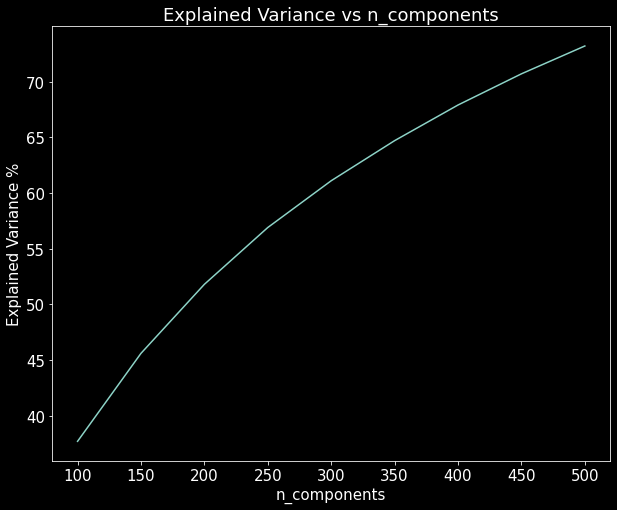

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(list(explained_var_dict.keys()), list(explained_var_dict.values()))
plt.xlabel('n_components')
plt.ylabel('Explained Variance %')
plt.title('Explained Variance vs n_components')
plt.show()

We will go for atleast 60% explained variance for n_components = 350, as the increment in Variance Explained isn't much great after 350 components so to avoid higher dimensionalities, we will go for 350.

In [ ]:
svd1 = TruncatedSVD(350, random_state=12345)
Reduced_RQ_TfIdf = svd1.fit_transform(RequiredQual_TfIdf_scaled)
Reduced_RQ_TfIdf.shape

(18460, 350)

In [ ]:
Loadings_RQ = pd.DataFrame((svd1.components_.T * np.sqrt(svd1.explained_variance_)).T,columns=vocab1).T
Loadings_RQ.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349
ability,0.056005,0.030511,0.115095,0.013558,-0.042346,0.019122,-0.013880,0.023774,-0.014646,-0.022055,0.002760,-0.018949,0.002318,-0.010663,-0.019221,-0.000524,0.017999,0.012359,0.003079,-0.018562,-0.021370,-0.009046,-0.005249,-0.012349,-0.009427,-0.010165,0.000451,-0.010007,-0.004949,-0.001972,-0.003559,0.008262,0.002832,-0.003261,-0.003141,0.006212,-0.006209,-0.001684,-0.006531,-0.008671,...,0.000755,-0.001658,-0.000908,-0.001308,0.000361,-0.001098,0.001507,-0.000102,-0.000605,0.000240,-0.000424,-0.000764,-0.000758,0.001297,0.001248,0.000126,-0.000866,-0.000526,0.000503,0.000424,0.000156,-0.000311,-0.000107,-0.000511,-0.000040,-0.000571,0.000175,-0.000443,0.000097,0.000535,-0.000119,0.000161,-0.000176,-0.000200,-0.000638,-0.000725,0.000886,-0.000695,-0.000633,-0.000997
able,0.001746,0.000212,0.002637,0.000187,0.000684,-0.000153,-0.000945,0.000189,0.001541,0.000533,0.000959,0.002562,-0.000487,0.002616,-0.000770,-0.002438,-0.000490,-0.000779,-0.002732,0.002382,0.001399,0.000067,-0.000132,0.000019,-0.000952,0.000686,0.001204,-0.000115,-0.000781,0.000291,0.001435,-0.002560,-0.001050,-0.000180,0.000789,0.002285,0.002422,-0.000505,-0.000966,-0.000157,...,-0.001126,-0.001248,0.006527,-0.004110,0.006297,0.006306,-0.000492,0.004281,-0.000182,-0.001353,0.003128,-0.000152,-0.002912,-0.000881,-0.007092,0.002897,0.001986,0.004076,-0.000502,-0.001665,-0.002525,0.000059,-0.001980,-0.005734,-0.000610,-0.000873,0.000890,0.001228,-0.001168,-0.001458,-0.002542,-0.001100,-0.002481,0.001232,0.001619,0.001786,0.004653,-0.002317,-0.003819,-0.002467
abovementioned,0.000142,0.000043,0.000177,-0.000325,0.000208,0.000110,-0.000335,0.000144,-0.000062,-0.000066,0.000127,0.000050,-0.000048,-0.000173,-0.000280,-0.000417,-0.000069,0.000111,0.000112,-0.000010,-0.000099,-0.000308,0.000118,0.000286,0.000232,-0.000273,-0.000033,-0.000108,-0.000303,-0.000445,-0.000070,-0.000213,0.000124,0.000003,0.000328,0.000288,0.000191,-0.000436,0.000221,0.000097,...,-0.000064,-0.000010,0.000509,-0.000441,-0.000367,-0.000532,-0.000333,-0.000527,-0.000323,0.000013,0.000666,-0.000144,-0.000010,-0.000638,0.000403,0.000044,0.000453,0.000227,0.000078,-0.000242,0.000371,0.000255,0.000406,0.000001,0.000156,0.000184,0.000269,-0.000168,-0.000273,0.000889,-0.000080,0.000131,0.000130,-0.000077,0.000053,-0.000130,0.000893,-0.000054,-0.000157,-0.000453
abroad,0.001229,0.001718,-0.000263,-0.001510,0.002221,-0.001068,-0.003666,0.001058,0.000641,-0.001327,0.001167,0.001767,0.000705,-0.001483,-0.001592,-0.000438,0.000085,-0.000284,0.000878,0.002033,-0.001970,-0.002721,-0.000502,-0.000004,0.001077,-0.001300,0.002045,-0.000448,0.001074,0.004139,0.000901,-0.001377,0.000605,-0.001438,-0.001125,-0.001060,0.001024,0.000188,0.000329,-0.001606,...,-0.000973,0.000031,0.002113,-0.001095,-0.002830,-0.001334,-0.000437,-0.001276,-0.001701,-0.004028,-0.002071,-0.003530,-0.000656,-0.000899,0.000984,0.000363,-0.001439,0.002330,-0.005218,0.000217,-0.003281,0.001182,0.000629,-0.000175,-0.001856,-0.000559,0.003415,-0.000908,-0.003938,-0.001174,0.000402,-0.003176,-0.002460,-0.001056,0.002021,0.002605,0.002984,-0.003648,-0.003409,-0.000558
ac,0.000093,0.000119,-0.000160,0.000013,-0.000022,0.000093,-0.000349,0.000145,0.000045,0.000178,0.000478,-0.000173,0.000224,0.000205,-0.000053,-0.000194,-0.000261,-0.000264,-0.000184,-0.000056,-0.000038,-0.000015,-0.000451,0.000132,0.000334,0.000392,-0.000179,-0.000302,0.000567,-0.000216,0.000041,0.000311,-0.000160,0.000281,-0.000055,-0.000222,0.000552,0.000180,0.000124,0.000129,...,0.000042,-0.000348,0.000210,-0.000301,0.000561,0.000147,0.000018,-0.000781,-0.000699,0.000384,0.000570,-0.001129,0.001374,0.000154,0.000634,0.000287,-0.000970,0.001155,-0.001006,0.000621,-0.000602,0.001602,-0.000615,-0.001118,0.

## Segmentation using KMeans Clustering

### Quantitative Evaluatin

#### Silhouette Coefficient

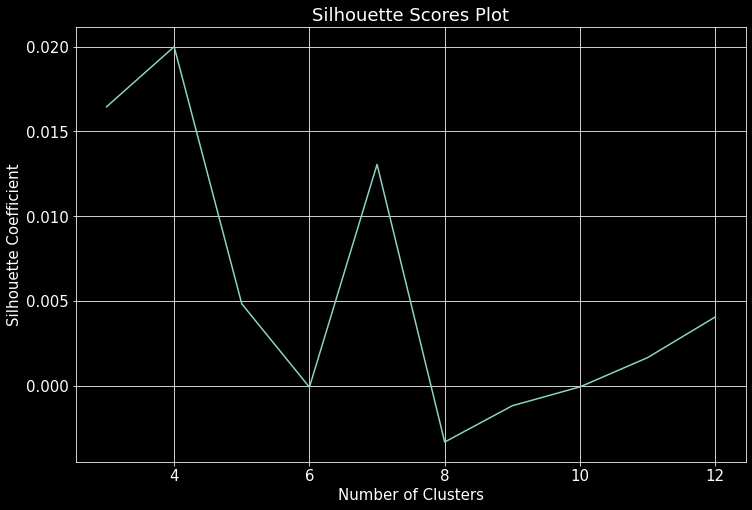

In [ ]:
# Calculating SC for K=3 through K=12 and Plotting the Result
k_range = range(3, 13)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, init='k-means++', max_iter=100, random_state=12345)
    km.fit(Reduced_RQ_TfIdf)
    scores.append(silhouette_score(Reduced_RQ_TfIdf, km.labels_))
plt.figure(figsize=(12,8))
plt.plot(k_range, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Scores Plot')
plt.grid(True)
plt.show()

Sc score is highest for 4 clusters solution and then for 7 clusters solution, We will do segment size check to choose between these two optimal options.

#### Segment Size Check

In [ ]:
km_3 = KMeans(n_clusters=3, init='k-means++', max_iter=100, random_state=12345).fit(Reduced_RQ_TfIdf)
km_4 = KMeans(n_clusters=4, init='k-means++', max_iter=100, random_state=12345).fit(Reduced_RQ_TfIdf)
km_5 = KMeans(n_clusters=5, init='k-means++', max_iter=100, random_state=12345).fit(Reduced_RQ_TfIdf)
km_6 = KMeans(n_clusters=6, init='k-means++', max_iter=100, random_state=12345).fit(Reduced_RQ_TfIdf)
km_7 = KMeans(n_clusters=7, init='k-means++', max_iter=100, random_state=12345).fit(Reduced_RQ_TfIdf)
km_8 = KMeans(n_clusters=8, init='k-means++', max_iter=100, random_state=12345).fit(Reduced_RQ_TfIdf)

In [ ]:
SegmentDF = pd.DataFrame(index=range(0,8))
for km in [km_3, km_4, km_5, km_6, km_7, km_8]:
    SegmentDF = pd.concat((SegmentDF,((pd.Series(km.labels_).value_counts()/sum(pd.Series(km.labels_).value_counts()))).sort_index()), axis=1)

SegmentDF.columns = ['km_3', 'km_4', 'km_5', 'km_6', 'km_7', 'km_8']

SegmentDF

,km_3,km_4,km_5,km_6,km_7,km_8
0,0.444420,0.006663,0.171343,0.211701,0.006663,0.006663
1,0.203738,0.437107,0.226923,0.116360,0.346533,0.102979
2,0.351842,0.352384,0.354280,0.164680,0.040520,0.065439
3,NaN,0.203846,0.006663,0.303954,0.006771,0.167714
4,NaN,NaN,0.240791,0.006663,0.229577,0.067389
5,NaN,NaN,NaN,0.196641,0.143445,0.154063
6,NaN,NaN,NaN,NaN,0.226490,0.256717
7,NaN,NaN,NaN,NaN,NaN,0.179036


For 4 clusters solution, most of the data seems to be clustered in 2 clusters only whereas, in 7 clusters solution, it is quite well distributed. So we will go with 7 clusters solution.

#### Building the Final Kmeans Model with n_clusters =7

In [ ]:
km = KMeans(n_clusters=7, init='k-means++', max_iter=100, random_state=12345)

In [ ]:
km_res = km.fit(Reduced_RQ_TfIdf)
km_res

KMeans(max_iter=100, n_clusters=7, random_state=12345)

In [ ]:
# Getting the Cluster Centers from the Model
cluster_centers = np.array(km_res.cluster_centers_)

In [ ]:
# Sorting the Cluster Centers
sorted_vals = [cluster_centers[i].argsort() for i in range(0,np.shape(cluster_centers)[0])]

In [ ]:
# Creating Loadings Matrix with Absolute Values
Loadings_RQ_abs = Loadings_RQ.apply(lambda x: [np.abs(y) for y in x])

# Getting Top Words from Each Cluster
n_top_words = 10
for i in range(len(sorted_vals)):
  words = []
  for j in range(n_top_words):
    c_idx = sorted_vals[i][j]
    words.append(Loadings_RQ_abs.sort_values(by=c_idx, ascending=False)[c_idx].index[0])
  print(words)

['development', 'detail', 'good', 'education', 'personality', 'development', 'good', 'analytical', 'excellent', 'office']
['ability', 'degree', 'development', 'good', 'science', 'meet', 'deadline', 'detail', 'written', 'good']
['computer', 'education', 'ability', 'skill', 'detail', 'office', 'management', 'office', 'excel', 'presentation']
['degree', 'office', 'computer', 'analytical', 'good', 'plus', 'good', 'including', 'accounting', 'good']
['development', 'accounting', 'education', 'skill', 'excellent', 'office', 'environment', 'management', 'understanding', 'good']
['ability', 'education', 'player', 'excellent', 'development', 'solving', 'including', 'analytical', 'written', 'solving']
['degree', 'science', 'responsibility', 'written', 'detail', 'testing', 'analytical', 'solving', 'computer', 'service']


#### A Brief Summary of Each Cluster:
1. Cluster 1: This cluster is all about, good education, persoanlity development and anlytical skills.
2. Cluster 2: This cluster hints towards degree in science, written abillities and meeting the deadline.
3. Cluster 3: This clusters mainly focuses on computer skills like excel, office management and presentations abilities.
4. Cluster 4: This cluster is about degree in accounting, good computer skills and good anlytical skills.
5. Cluster 5: This cluster focuses on excellent office management skills, understanding office environment and accounting.
6. Cluster 6: This cluste mainly focuses on probelm solving skills, being a team player and analytical skills.
7. Cluster 7: This cluster is all about service responsibility, science degree and testing.

## How are these desired characteristics changing over time?

### using the Conditional Frequency Distribution

In [ ]:
RequiredQual_Year_df = pd.concat([RequiredQual_df, final_data.Year], axis=1)
RequiredQual_Year_df.head()

,RequiredQual,Year
0,perform job successfully individual must able ...,2004
1,bachelor degree master preferred excellent ski...,2004
2,degree environmentally related field year rele...,2004
3,advanced degree public health social science c...,2004
4,university degree economical background plus e...,2004


In [ ]:
RequiredQual_Year_grouped = RequiredQual_Year_df.groupby('Year').sum().reset_index()
RequiredQual_Year_grouped.head()

,Year,RequiredQual
0,2004,perform job successfully individual must able ...
1,2005,higher education accounting finance economics ...
2,2006,higher education preferably economics excellen...
3,2007,good knowledge bangladesh area street basic kn...
4,2008,higher education preferably marketing excellen...


In [ ]:
RequiredQual_Year_dict = {}
for i in range(RequiredQual_Year_grouped.shape[0]):
  RequiredQual_Year_dict[RequiredQual_Year_grouped.Year[i]] = word_tokenize(RequiredQual_Year_grouped.RequiredQual[i])

Enter some words separated by commas : science, audit, account, python, server


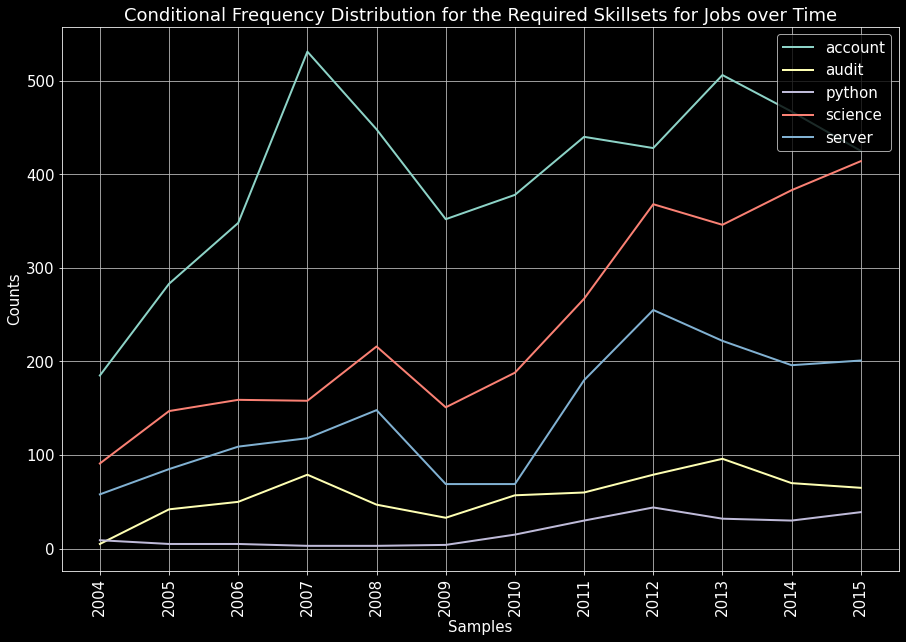

In [ ]:
target_input = input("Enter some words separated by commas : ")
cfd = nltk.ConditionalFreqDist(
    (target.strip(), year)
    for year in RequiredQual_Year_dict.keys()
    for word in RequiredQual_Year_dict[year]
    for target in target_input.split(',')
    if word.lower().startswith(target.strip()))
plt.figure(figsize=20,8))
plt.xlabel('Year')
plt.title('Conditional Frequency Distribution for the Required Skillsets for Jobs over Time')
cfd.plot()

# Company Profiling

## Data Cleaning and Pre-Processing

In [ ]:
Company_df = final_data.AboutC.dropna().reset_index(drop=True)
Company_df.head()

0    The International Research & Exchanges Board (...
1    The Caucasus Environmental NGO Network is a\nn...
2    Water User Associations Support Program (WUASP...
3    NetCall Communications is an ITSP specialized ...
4    Xalt LLC, more widely known as Xter.net, is on...
Name: AboutC, dtype: object

In [ ]:
Company_df = Company_df.apply(lambda x: clean_and_preprocess(x))
Company_df.head()

0    international research & exchange board irex u...
1    caucasus environmental ngo network nongovernme...
2    water user association support program wuasp $...
3    netcall communication itsp specialized providi...
4    xalt llc widely known xternet one leading isps...
Name: AboutC, dtype: object

In [ ]:
# Tokenizing the Corpus using word_tokenize
Company_corpus = word_tokenize(''.join(Company_df))
len(Company_corpus)

353874

## Frequency Distribution Plot

In [ ]:
fdist = FreqDist(Company_corpus)
fdist.items()

dict_items([('international', 3184), ('research', 368), ('&', 436), ('exchange', 139), ('board', 280), ('irex', 151), ('usbased', 60), ('private', 623), ('nonprofit', 451), ('organization', 2525), ('armenia', 8548), ('yerevan', 1283), ('office', 900), ('established', 1943), ('place', 25), ('interested', 36), ('individual', 276), ('obtain', 34), ('uptodate', 22), ('information', 3806), ('study', 60), ('professional', 290), ('internship', 27), ('opportunity', 778), ('unites', 24), ('state', 698), ('collaborates', 24), ('national', 522), ('government', 901), ('branch', 818), ('local', 748), ('ngo', 445), ('institution', 331), ('higher', 113), ('education', 667), ('promotion', 117), ('administered', 44), ('program', 1583), ('goal', 261), ('make', 88), ('american', 323), ('academic', 53), ('experience', 163), ('available', 279), ('qualified', 81), ('individualcaucasus', 1), ('environmental', 247), ('network', 669), ('nongovernmental', 162), ('since', 827), ('establishment', 208), ('cenn', 1

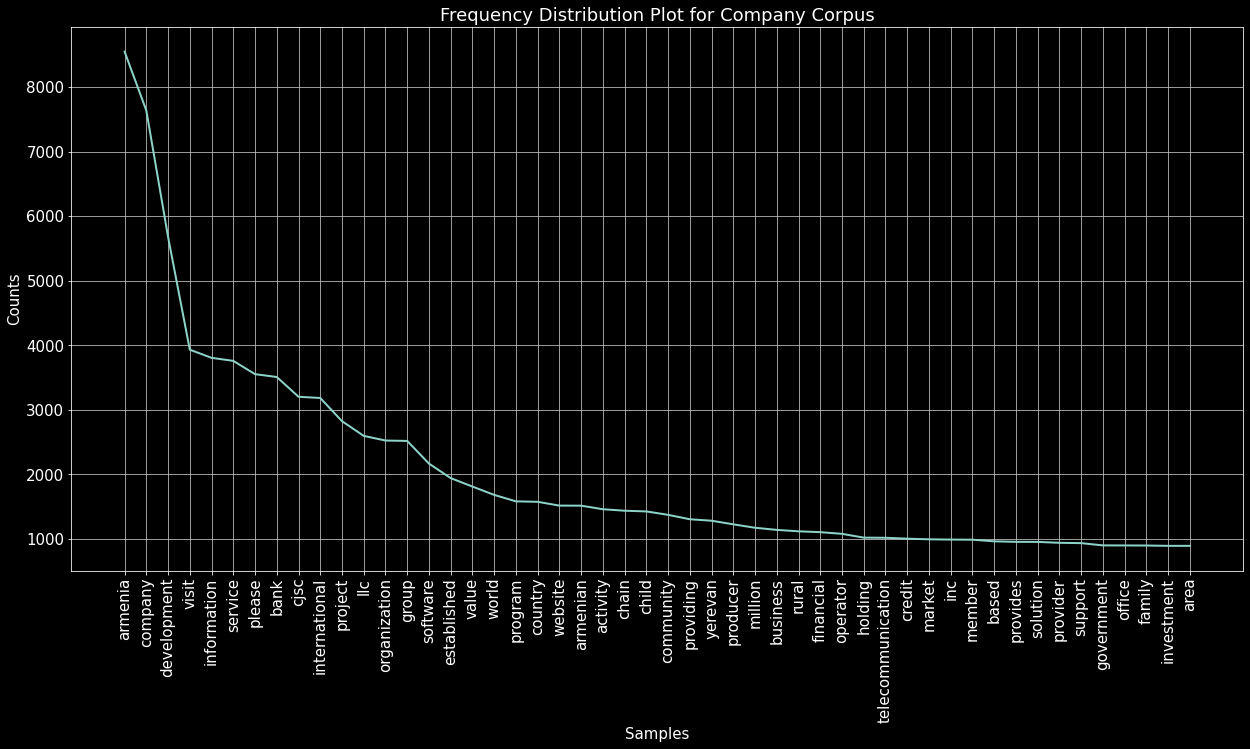

In [ ]:
plt.figure(figsize=(21, 10))
plt.title('Frequency Distribution Plot for Company Corpus')
fdist.plot(50)

## Creating a Word Cloud

In [ ]:
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(Company_corpus))

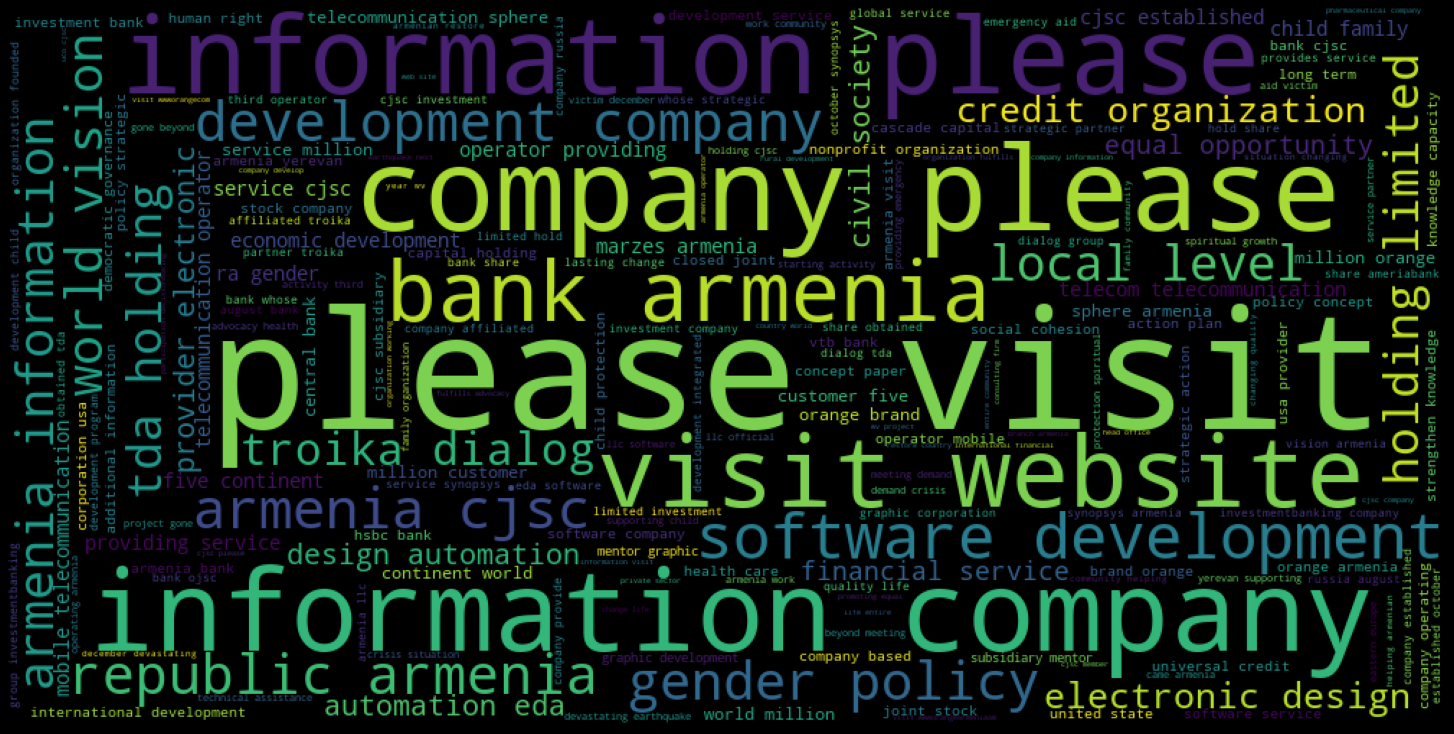

In [ ]:
# plot the WordCloud image                        
plt.figure(figsize = (22, 10), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)  
plt.show()

## Topic Modelling using LatentDirichletAllocation(LDA)

### Vectorization of Corpus using Tf-Idf Vectorizer brfore Topic Modelling

In [ ]:
TfIdf_vect2 = TfidfVectorizer(min_df = 0.001, max_df=0.9, ngram_range=(1,1))

In [ ]:
Company_TfIdf = TfIdf_vect2.fit_transform(Company_df)
Company_TfIdf

<15765x2211 sparse matrix of type '<class 'numpy.float64'>'
	with 281901 stored elements in Compressed Sparse Row format>

In [ ]:
vocab2 = TfIdf_vect2.get_feature_names()
vocab2 = np.array(vocab2)

### Topic Modelling

In [ ]:
lda = LatentDirichletAllocation(n_components=10, learning_method='batch', max_iter=100, random_state=12345)

In [ ]:
topics_lda = lda.fit_transform(Company_TfIdf)
topic_words = lda.components_

In [ ]:
n_top_words = 15
topic_summaries = []
for i, topic_dist in enumerate(topic_words):
    topic_word = np.array(vocab2)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_word))

topic_summaries

['armenia llc company pharmaceutical official postal wwwinecobankam bank hsbc brand representative cjsc please haypost check',
 'company bank found investment information limited detailed ameriabank tda dialog troika cjsc share holding osce',
 'company llc ltd engaged import wwwquestradeam specialized yerevan hotel importing information armenia production trade country',
 'telecommunication operator orange service million telecom world armenia software cascade france cjsc sphere continent company',
 'organization development project armenia international procredit rural value credit group bank finca program support caucasus',
 'wwwashibam software llc company development solution website usa international armenia represented logistics new york detail',
 'synopsys graphic mentor provider design electronic automation eda corporation service subsidiary armenia cjsc software usa',
 'armenia vtb mobile leading vivacellmts operator international bank consulting company network currently russ

#### Topic Models:
1. Brand Representative
2. Share Holding
3. Bank Investment
4. Trade Country
5. Telecom Operator
6. Project Development
7. Credit Value
8. Company Website
9. New York, USA
10. Graphic Design
11. Electronic Automation
12. Mobile Leading Operator
13. Consulting Company
14. Please Visit Company Website
15. Equal Opportunity

# IT Job Classification:
## from Job and Company Description
## using Supervised Learning

## Data Preparation

In [ ]:
data_sl = final_data[['JobDescription', 'AboutC', 'IT']]
data_sl.head()

,JobDescription,AboutC,IT
0,AMERIA Investment Consulting Company is seekin...,NaN,0
1,NaN,The International Research & Exchanges Board (...,0
2,Public outreach and strengthening of a growing...,The Caucasus Environmental NGO Network is a\nn...,0
3,The LEAD (Local Enhancement and Development fo...,NaN,0
4,Haypost CJSC is looking for a qualified and mo...,NaN,1


#### Dropping the observations with Missing Values

In [ ]:
data_sl = data_sl.dropna().reset_index(drop=True)
data_sl.shape

(14278, 3)

In [ ]:
data_sl['Text'] = data_sl.JobDescription + ' ' + data_sl.AboutC

#### Splitting into Feature and Target

In [ ]:
X = data_sl['Text']
y = data_sl['IT'] 

#### Splitting into Train and Test

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=12345)
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(9994,)
(4284,)
(9994,)
(4284,)


## Data Cleaning and Pre-Processing using the UDF

In [ ]:
train_x = train_x.astype('str')
test_x = test_x.astype('str')

In [ ]:
train_x = train_x.apply(lambda x: clean_and_preprocess(x))
test_x = test_x.apply(lambda x: clean_and_preprocess(x))

In [ ]:
print(train_x.head())
print(test_x.head())

3812     click web design seeking candidate fill longte...
873      primary objective position development mainten...
14274    incumbent responsible supporting director orga...
2750     metakortex seeking software engineer responsib...
10127    incumbent responsible va crm billing service s...
Name: Text, dtype: object
8056     kamurj uco llc seeking credit officer work len...
10963    timeless llc seeking analyticallyoriented qual...
12811    net developer work extending maintaining suppo...
2655     direct supervision head strategic planning ana...
7477     incumbent responsible consulting term legal is...
Name: Text, dtype: object


### Vectorization using TfidfVectorizer ( Word level Uni-Gram )

In [ ]:
Tfidf_vect3 = TfidfVectorizer(min_df = 10, max_df=0.9, ngram_range=(1, 1))

In [ ]:
train_tfidf = Tfidf_vect3.fit_transform(train_x)
train_tfidf

<9994x3542 sparse matrix of type '<class 'numpy.float64'>'
	with 360978 stored elements in Compressed Sparse Row format>

In [ ]:
test_tfidf = Tfidf_vect3.transform(test_x)
test_tfidf

<4284x3542 sparse matrix of type '<class 'numpy.float64'>'
	with 150041 stored elements in Compressed Sparse Row format>

In [ ]:
vocab3 = Tfidf_vect3.get_feature_names()
vocab3 = np.array(vocab3)

In [ ]:
train_dtm = pd.DataFrame(train_tfidf.toarray(), columns=vocab3)
train_dtm.head()

,aaa,ab,abandoned,ability,able,abovyan,abroad,absence,abuse,ac,academic,academy,acbacredit,accelerate,accelerating,accept,accepted,accepting,access,accessible,accessing,accessory,accommodation,accomplish,accomplished,accomplishing,accomplishment,accordance,according,account,accountability,accountable,accountant,accounting,accuracy,accurate,accurately,acdi,acdivoca,achieve,...,wwwrotapharmcouk,wwwrotapharmru,wwwserviercom,wwwsflprocom,wwwsmartam,wwwsonicsinccom,wwwsourciocom,wwwspaykacom,wwwsynopsysam,wwwsynopsyscom,wwwtangeram,wwwtoweram,wwwtumoorg,wwwundpam,wwwunibankam,wwwvirtualsolutionam,wwwvirtualsolutioncom,wwwvirtualsolutionde,wwwvmwarecom,wwwvtbam,wwwwebbfontainecom,wwwzangicom,wwwzeppelinam,xalt,xternet,year,yeghegnadzor,yerevan,yerevanbased,yet,york,yorkbased,young,youth,zangi,zeppelin,zone,zte,zusammenarbeit,zvartnots
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.197646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
train_dtm.shape

(9994, 3542)

We still have much High Dimensionality than needed, so we will reduce dimensions using TruncatedSVD

### Scaling the Data using MaxAbsScaler before Dimension Reduction

In [ ]:
sc2 = MaxAbsScaler()
train_tfidf_scaled = sc2.fit_transform(train_tfidf)
test_tfidf_scaled = sc2.transform(test_tfidf)

### Dimension Reduction using TruncatedSVD

In [ ]:
explained_var_dict = {}
for i in [100,150,200,250,300,350,400,450,500]:
  svd = TruncatedSVD(i, random_state=12345)
  svd.fit(train_tfidf_scaled)
  explained_var_dict[i] = round(svd.explained_variance_ratio_.sum()*100,1)
explained_var_dict

{100: 38.4,
 150: 46.1,
 200: 51.9,
 250: 56.6,
 300: 60.6,
 350: 64.0,
 400: 67.0,
 450: 69.6,
 500: 72.0}

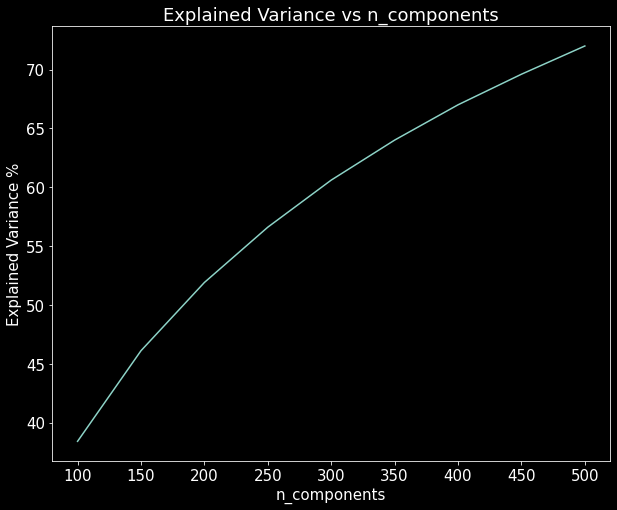

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(list(explained_var_dict.keys()), list(explained_var_dict.values()))
plt.xlabel('n_components')
plt.ylabel('Explained Variance %')
plt.title('Explained Variance vs n_components')
plt.show()

We will go for atleast 60% explained variance for n_components = 300, as the increment in Variance Explained isn't much great after 300 components so to avoid higher dimensionalities, we will go for 300.

In [ ]:
svd2 = TruncatedSVD(300, random_state=12345)
reduced_train_tfidf = svd2.fit_transform(train_tfidf_scaled)
reduced_test_tfidf = svd2.transform(test_tfidf_scaled)
reduced_train_tfidf.shape

(9994, 300)

### Target Classes are Imbalanced

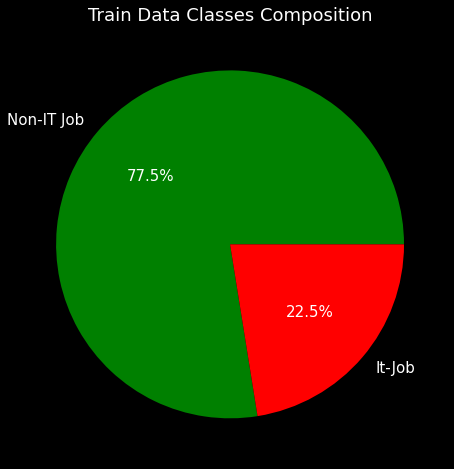

In [ ]:
plt.figure(figsize=(8,8))
plt.pie(train_y.value_counts(), autopct='%.1f%%', labels=['Non-IT Job', 'It-Job'], colors=['g', 'r'])
plt.title('Train Data Classes Composition')
plt.show()

### Balancing the Data by OverSampling

####using RandomOverSampler

In [ ]:
ros = RandomOverSampler(random_state=12345)

In [ ]:
train_tfidf_os, train_y_os = ros.fit_resample(reduced_train_tfidf, train_y)

In [ ]:
print(train_tfidf_os.shape)
print(train_y_os.shape)

(15496, 300)
(15496,)


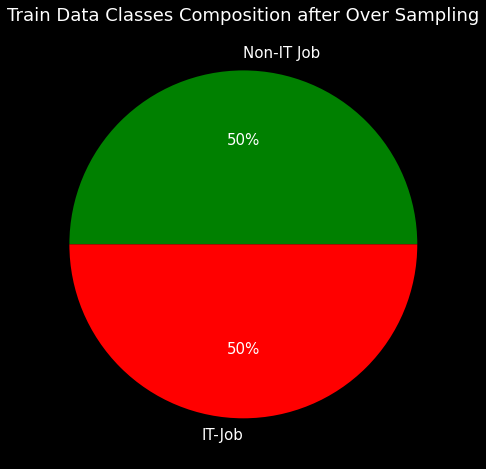

In [ ]:
plt.figure(figsize=(8,8))
plt.pie(train_y_os.value_counts(), autopct='%d%%', labels=['Non-IT Job','IT-Job'], colors=['g', 'r'])
plt.title('Train Data Classes Composition after Over Sampling')
plt.show()

In [ ]:
target_classes = ['Non-IT Job', 'IT Job']

Classes are balanced now, So we will move onto our next step, Data Modelling

## Data Modelling

#### using
*   Logistic Regression
*   Bernoulli's Naive Bayes
*   Linear Support Vector Machine
*   Multi Layer Perceptron



### Logistic Regression

In [ ]:
logreg_clf = LogisticRegression(random_state=12345)

In [ ]:
logreg_clf.fit(train_tfidf_os, train_y_os)

LogisticRegression(random_state=12345)

In [ ]:
print('Train Accuracy :',accuracy_score(train_y_os, logreg_clf.predict(train_tfidf_os)),' | ','Test Accuracy :',accuracy_score(test_y, logreg_clf.predict(reduced_test_tfidf)))

Train Accuracy : 0.9026845637583892  |  Test Accuracy : 0.903828197945845


In [ ]:
print('Train AUC:',roc_auc_score(train_y_os, logreg_clf.predict_proba(train_tfidf_os)[:,1]),' | ','Test AUC :',roc_auc_score(test_y, logreg_clf.predict_proba(reduced_test_tfidf)[:,1]))

Train AUC: 0.9666613466822354  |  Test AUC : 0.9649671956167658


In [ ]:
logreg_acc = accuracy_score(test_y, logreg_clf.predict(reduced_test_tfidf))
logreg_auc = roc_auc_score(test_y, logreg_clf.predict_proba(reduced_test_tfidf)[:,1])

In [ ]:
print(classification_report(test_y, logreg_clf.predict(reduced_test_tfidf), target_names=target_classes))

              precision    recall  f1-score   support

  Non-IT Job       0.96      0.91      0.93      3268
      IT Job       0.75      0.89      0.81      1016

    accuracy                           0.90      4284
   macro avg       0.86      0.90      0.87      4284
weighted avg       0.91      0.90      0.91      4284



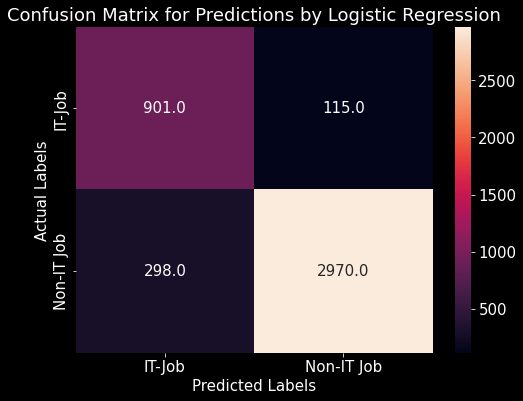

In [ ]:
cm_logreg = confusion_matrix(test_y, logreg_clf.predict(reduced_test_tfidf), labels=[1,0])
plt.figure(figsize=(8,6))
sns.heatmap(cm_logreg, annot=True,  fmt='.1f', xticklabels = ['IT-Job', 'Non-IT Job'], yticklabels = ['IT-Job', 'Non-IT Job'])
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix for Predictions by Logistic Regression')
plt.show()

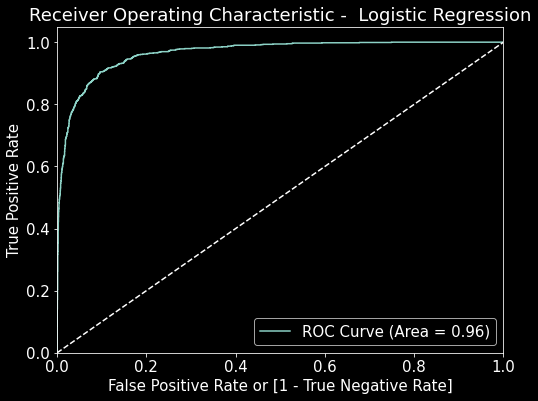

In [ ]:
fpr, tpr, thresholds = roc_curve(test_y, logreg_clf.predict_proba(reduced_test_tfidf)[:,1], drop_intermediate = False )
plt.figure(figsize=(8, 6))
plt.plot( fpr, tpr, label='ROC Curve (Area = %0.2f)' % roc_auc_score(test_y, logreg_clf.predict_proba(reduced_test_tfidf)[:,1]))
plt.plot([0, 1], [0, 1], 'w--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic -  Logistic Regression')
plt.legend(loc="lower right")
plt.show()

### Bernoulli Naive Bayes

In [ ]:
nb_clf = BernoulliNB()

In [ ]:
nb_clf.fit(train_tfidf_os, train_y_os)

BernoulliNB()

In [ ]:
print('Train Accuracy :',accuracy_score(train_y_os, nb_clf.predict(train_tfidf_os)),' | ','Test Accuracy :',accuracy_score(test_y, nb_clf.predict(reduced_test_tfidf)))

Train Accuracy : 0.8343443469282396  |  Test Accuracy : 0.8520074696545284


In [ ]:
print('Train AUC:',roc_auc_score(train_y_os, nb_clf.predict_proba(train_tfidf_os)[:,1]),' | ','Test AUC :',roc_auc_score(test_y, nb_clf.predict_proba(reduced_test_tfidf)[:,1]))

Train AUC: 0.9014407251898937  |  Test AUC : 0.9067704367813877


In [ ]:
nb_acc = accuracy_score(test_y, nb_clf.predict(reduced_test_tfidf))
nb_auc = roc_auc_score(test_y, nb_clf.predict_proba(reduced_test_tfidf)[:,1])

In [ ]:
print(classification_report(test_y, nb_clf.predict(reduced_test_tfidf), target_names=target_classes))

              precision    recall  f1-score   support

  Non-IT Job       0.94      0.85      0.89      3268
      IT Job       0.63      0.81      0.71      1016

    accuracy                           0.84      4284
   macro avg       0.78      0.83      0.80      4284
weighted avg       0.86      0.84      0.85      4284



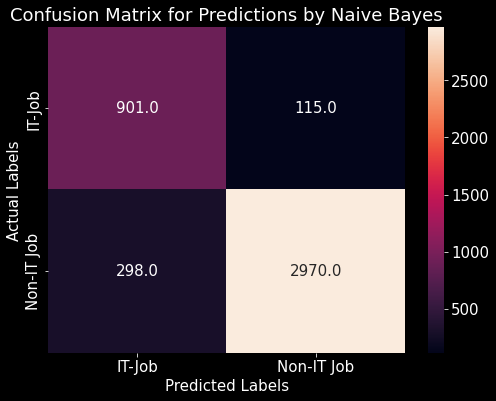

In [ ]:
cm_nb = confusion_matrix(test_y, nb_clf.predict(reduced_test_tfidf), labels=[1,0])
plt.figure(figsize=(8,6))
sns.heatmap(cm_logreg, annot=True,  fmt='.1f', xticklabels = ["IT-Job", "Non-IT Job"] , yticklabels = ["IT-Job", "Non-IT Job"])
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix for Predictions by Naive Bayes')
plt.show()

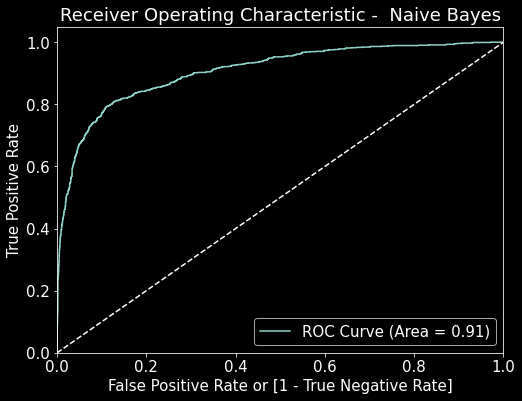

In [ ]:
fpr, tpr, thresholds = roc_curve( test_y, nb_clf.predict_proba(reduced_test_tfidf)[:,1], drop_intermediate = False )
plt.figure(figsize=(8, 6))
plt.plot( fpr, tpr, label='ROC Curve (Area = %0.2f)' % roc_auc_score(test_y, nb_clf.predict_proba(reduced_test_tfidf)[:,1]))
plt.plot([0, 1], [0, 1], 'w--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic -  Naive Bayes')
plt.legend(loc="lower right")
plt.show()

### Linear Support Vector Machine

In [ ]:
lsvc = SVC(kernel='linear', gamma='auto', probability=True)

In [ ]:
lsvc.fit(train_tfidf_os, train_y_os)

SVC(gamma='auto', kernel='linear', probability=True)

In [ ]:
print('Train Accuracy :',accuracy_score(train_y_os, lsvc.predict(train_tfidf_os)),' | ','Test Accuracy :',accuracy_score(test_y, lsvc.predict(reduced_test_tfidf)))

Train Accuracy : 0.909783169850284  |  Test Accuracy : 0.9084967320261438


In [ ]:
print('Train AUC:',roc_auc_score(train_y_os, lsvc.predict_proba(train_tfidf_os)[:,1]),' | ','Test AUC :',roc_auc_score(test_y, lsvc.predict_proba(reduced_test_tfidf)[:,1]))

Train AUC: 0.9649091833514615  |  Test AUC : 0.9628583424088514


In [ ]:
lsvc_acc = accuracy_score(test_y, lsvc.predict(reduced_test_tfidf))
lsvc_auc = roc_auc_score(test_y, lsvc.predict_proba(reduced_test_tfidf)[:,1])

In [ ]:
print(classification_report(test_y, lsvc.predict(reduced_test_tfidf), target_names=target_classes))

              precision    recall  f1-score   support

 Non-IT Jobs       0.97      0.90      0.93      3268
     IT Jobs       0.74      0.90      0.81      1016

    accuracy                           0.90      4284
   macro avg       0.85      0.90      0.87      4284
weighted avg       0.91      0.90      0.90      4284



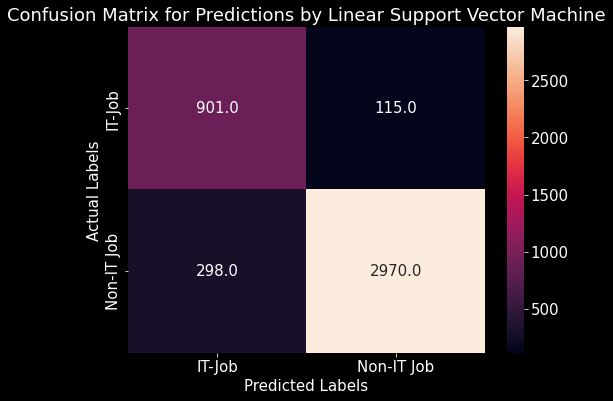

In [ ]:
cm_lsvc = confusion_matrix(test_y, lsvc.predict(reduced_test_tfidf), labels=[1,0])
plt.figure(figsize=(8,6))
sns.heatmap(cm_logreg, annot=True,  fmt='.1f', xticklabels = ["IT-Job", "Non-IT Job"] , yticklabels = ["IT-Job", "Non-IT Job"] )
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix for Predictions by Linear Support Vector Machine')
plt.show()

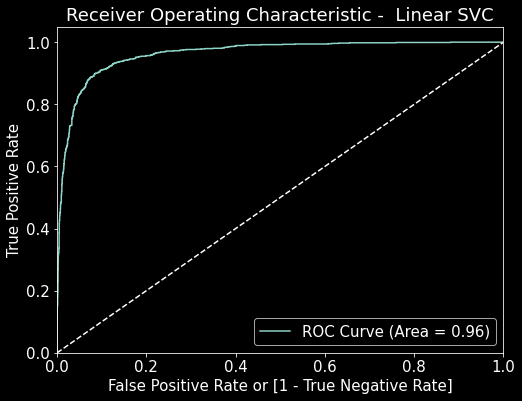

In [ ]:
fpr, tpr, thresholds = roc_curve( test_y, lsvc.predict_proba(reduced_test_tfidf)[:,1], drop_intermediate = False )
with plt.style.context('dark_background'):
  plt.figure(figsize=(8, 6))
  plt.plot( fpr, tpr, label='ROC Curve (Area = %0.2f)' % roc_auc_score(test_y, lsvc.predict_proba(reduced_test_tfidf)[:,1]))
  plt.plot([0, 1], [0, 1], 'w--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic - Linear SVC')
  plt.legend(loc="lower right")
  plt.show()

### Artifical Neural Network - Multi Layer Perceptron

#### using Sequential Model with Dense Layers

In [ ]:
callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [ ]:
# Initializing our Model
mlp = Sequential()

In [ ]:
print('Input Dimensions should be :',train_tfidf_os.shape[1])
print('Maximum Number of Nodes per Layer Should be around :',2/3*train_tfidf_os.shape[1] + train_y_os.nunique()-1)
print('Nodes for the output layer should be around :',train_y_os.nunique()-1)

Input Dimensions should be : 300
Maximum Number of Nodes per Layer Should be around : 201.0
Nodes for the output layer should be around : 1


In [ ]:
# Adding the Input Layer
mlp.add(Dense(units = 200, kernel_initializer = 'uniform', activation = 'softmax', input_dim = 300))

# Adding the Output Layer
mlp.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

In [ ]:
# Compiling Neural Network
mlp.compile(optimizer = 'adam', loss = 'binary_crossentropy', weighted_metrics = ['accuracy'])

In [ ]:
# Fitting our Model 
mlp.fit(train_tfidf_os, train_y_os, batch_size = 10, epochs = 100, callbacks=callback, validation_data=(reduced_test_tfidf, test_y))

Epoch 1/100
1550/1550 [==============================] - 8s 4ms/step - loss: 0.6618 - accuracy: 0.7434 - val_loss: 0.5799 - val_accuracy: 0.9010
Epoch 2/100
1550/1550 [==============================] - 6s 4ms/step - loss: 0.4661 - accuracy: 0.8829 - val_loss: 0.3631 - val_accuracy: 0.9024
Epoch 3/100
1550/1550 [==============================] - 6s 4ms/step - loss: 0.3210 - accuracy: 0.8895 - val_loss: 0.2931 - val_accuracy: 0.9008
Epoch 4/100
1550/1550 [==============================] - 9s 6ms/step - loss: 0.2729 - accuracy: 0.8957 - val_loss: 0.2697 - val_accuracy: 0.9034
Epoch 5/100
1550/1550 [==============================] - 7s 4ms/step - loss: 0.2531 - accuracy: 0.9013 - val_loss: 0.2543 - val_accuracy: 0.9064
Epoch 6/100
1550/1550 [==============================] - 7s 4ms/step - loss: 0.2419 - accuracy: 0.9060 - val_loss: 0.2552 - val_accuracy: 0.9050
Epoch 7/100
1550/1550 [==============================] - 6s 4ms/step - loss: 0.2344 - accuracy: 0.9092 - val_loss: 0.2458 - val_ac

In [ ]:
mlp.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 200)               60200     
                                                                 
 dense_10 (Dense)            (None, 1)                 201       
                                                                 
Total params: 60,401
Trainable params: 60,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print('Accuracy for Training :',accuracy_score(train_y_os, mlp.predict(train_tfidf_os)>0.5),' | ', 'Accuracy for Testing :',accuracy_score(test_y, mlp.predict(reduced_test_tfidf)>0.5))
mlp_acc = accuracy_score(test_y, mlp.predict(reduced_test_tfidf)>0.5)

Accuracy for Training : 0.9858027878162107  |  Accuracy for Testing : 0.9411764705882353


In [ ]:
print('AUC for Training :',roc_auc_score(train_y_os, mlp.predict(train_tfidf_os)),' | ', 'AUC for Testing :',roc_auc_score(test_y, mlp.predict(reduced_test_tfidf)))
mlp_auc = roc_auc_score(test_y, mlp.predict(reduced_test_tfidf))

AUC for Training : 0.9981858608773152  |  AUC for Testing : 0.9778305375919197


In [ ]:
print(classification_report(test_y, mlp.predict(reduced_test_tfidf)>0.5, target_names = target_classes))

              precision    recall  f1-score   support

  Non-IT Job       0.97      0.95      0.96      3268
      IT Job       0.86      0.90      0.88      1016

    accuracy                           0.94      4284
   macro avg       0.91      0.93      0.92      4284
weighted avg       0.94      0.94      0.94      4284



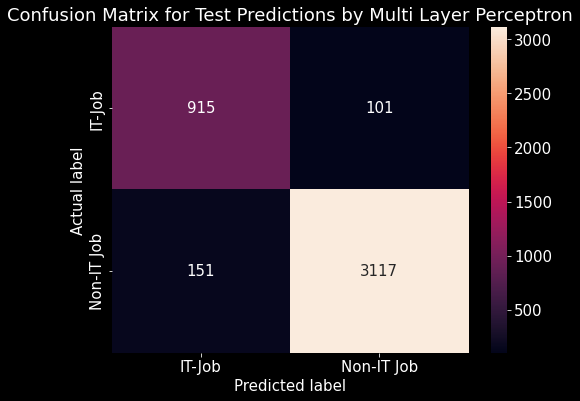

In [ ]:
cm_mlp = confusion_matrix(test_y, mlp.predict(reduced_test_tfidf)>0.5, labels=[1,0])
plt.figure(figsize=(8,6))
sns.heatmap(cm_mlp, annot=True,  fmt='d', xticklabels = ["IT-Job", "Non-IT Job"] , yticklabels = ["IT-Job", "Non-IT Job"] )
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix for Test Predictions by Multi Layer Perceptron')
plt.show()

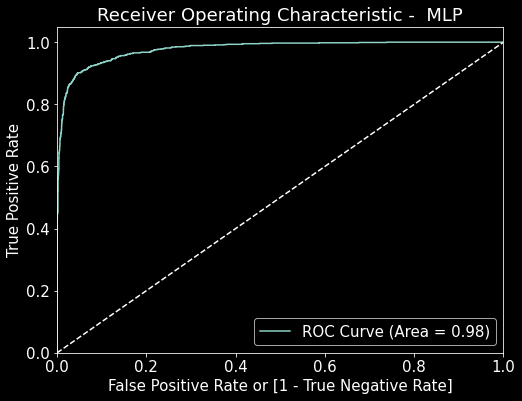

In [ ]:
mlp_pred_prob = mlp.predict(reduced_test_tfidf)
fpr, tpr, thresholds = roc_curve(test_y, mlp_pred_prob, drop_intermediate = False )
plt.figure(figsize=(8, 6))
plt.plot( fpr, tpr, label='ROC Curve (Area = %0.2f)' % roc_auc_score(test_y, mlp_pred_prob))
plt.plot([0, 1], [0, 1], 'w--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic -  MLP')
plt.legend(loc="lower right")
plt.show()

### Conclusion:

In [ ]:
pd.DataFrame({'Test Accuracy': [logreg_acc, nb_acc, lsvc_acc, mlp_acc],
             'Test AUC': [logreg_auc, nb_auc, lsvc_auc, mlp_auc]}, index=['Logistic Regression', 'Naive Bayes', 'Linear SVC', 'MLP'])

,Test Accuracy,Test AUC
Logistic Regression,0.903828,0.964967
Naive Bayes,0.852007,0.906770
Linear SVC,0.908497,0.962858
MLP,0.941176,0.977831


Amongst all, MLP Model gave the best Test Accuracy and AUC both. So we will use it to make our test predictions.

In [ ]:
test_predictions_df = pd.DataFrame({'Reviews':test_x.values,
                                    'Actual IT':test_y.values,
                                    'Predicted IT':[1 if x[0] else 0 for x in mlp.predict(reduced_test_tfidf)>0.5]})
test_predictions_df

,Reviews,Actual IT,Predicted IT
0,kamurj uco llc seeking credit officer work len...,0,0
1,timeless llc seeking analyticallyoriented qual...,0,0
2,net developer work extending maintaining suppo...,1,1
3,direct supervision head strategic planning ana...,0,0
4,incumbent responsible consulting term legal is...,0,0
...,...,...,...
4279,armenia international airport looking accounta...,0,0
4280,candidate administrate window service addition...,0,0
4281,direct supervision program manager pm program ...,0,0
4282,acdivoca looking motivated person take new pos...,0,0


# Similarity of Jobs:

### using JobPost Details

## using Word2vec

### Data Cleaning and Pre-Processing

In [ ]:
jobpost_df = final_data.Title.fillna('') + ' ' + final_data.Company.fillna('') + ' ' + final_data.JobDescription.fillna('') + ' ' + final_data.JobRequirment.fillna('') + ' ' + final_data.RequiredQual.fillna('') + ' ' + np.array(['Information Technology' if x else '' for x in final_data.IT])
jobpost_df = jobpost_df.astype('str')
jobpost_df.head()

0    Chief Financial Officer AMERIA Investment Cons...
1    Full-time Community Connections Intern (paid i...
2    Country Coordinator Caucasus Environmental NGO...
3    BCC Specialist Manoff Group The LEAD (Local En...
4    Software Developer Yerevan Brandy Company Hayp...
dtype: object

In [ ]:
jobpost_df = jobpost_df.apply(lambda x:clean_and_preprocess(x))
jobpost_df.head()

0    chief financial officer ameria investment cons...
1    fulltime community connection intern paid inte...
2    country coordinator caucasus environmental ngo...
3    bcc specialist manoff group lead local enhance...
4    software developer yerevan brandy company hayp...
dtype: object

In [ ]:
jobpost_corpus = [row.split(' ') for row in jobpost_df]
print(jobpost_corpus[:5])

[['chief', 'financial', 'officer', 'ameria', 'investment', 'consulting', 'company', 'ameria', 'investment', 'consulting', 'company', 'seeking', 'chief', 'financial', 'officer', 'position', 'manages', 'company', 'fiscal', 'administrative', 'function', 'provides', 'highly', 'responsible', 'technically', 'complex', 'staff', 'assistance', 'executive', 'director', 'work', 'performed', 'requires', 'high', 'level', 'technical', 'proficiency', 'financial', 'management', 'investment', 'management', 'well', 'management', 'supervisory', 'administrative', 'skill', 'supervises', 'financial', 'management', 'administrative', 'staff', 'including', 'assigning', 'responsibility', 'reviewing', 'employee', 'work', 'process', 'product', 'counseling', 'employee', 'giving', 'performance', 'evaluation', 'recommending', 'disciplinary', 'action', 'serf', 'member', 'management', 'team', 'participating', 'strategic', 'operational', 'planning', 'company', 'directs', 'oversees', 'company', 'financial', 'management'

In [ ]:
title_df = final_data.Title.apply(lambda x:clean_and_preprocess(x))
title_df.head()

0                              chief financial officer
1    fulltime community connection intern paid inte...
2                                  country coordinator
3                                       bcc specialist
4                                   software developer
Name: Title, dtype: object

In [ ]:
for i in range(len(jobpost_corpus)):
  jobpost_corpus[i].append(title_df[i])
print(jobpost_corpus[:5])

[['chief', 'financial', 'officer', 'ameria', 'investment', 'consulting', 'company', 'ameria', 'investment', 'consulting', 'company', 'seeking', 'chief', 'financial', 'officer', 'position', 'manages', 'company', 'fiscal', 'administrative', 'function', 'provides', 'highly', 'responsible', 'technically', 'complex', 'staff', 'assistance', 'executive', 'director', 'work', 'performed', 'requires', 'high', 'level', 'technical', 'proficiency', 'financial', 'management', 'investment', 'management', 'well', 'management', 'supervisory', 'administrative', 'skill', 'supervises', 'financial', 'management', 'administrative', 'staff', 'including', 'assigning', 'responsibility', 'reviewing', 'employee', 'work', 'process', 'product', 'counseling', 'employee', 'giving', 'performance', 'evaluation', 'recommending', 'disciplinary', 'action', 'serf', 'member', 'management', 'team', 'participating', 'strategic', 'operational', 'planning', 'company', 'directs', 'oversees', 'company', 'financial', 'management'

### Making a Word2vec Model using Continuous Bag of Words Method (CBOW)

In [ ]:
# Intitilazing the Model
w2v = Word2Vec(min_count=5, window=10, size=100, sample=6e-5, alpha=0.05, min_alpha=0.0005, negative=10, workers=-1)

In [ ]:
# Building the Vocabulary
w2v.build_vocab(jobpost_corpus, progress_per=10000)

In [ ]:
#Training the Model
w2v.train(jobpost_corpus, total_examples=w2v.corpus_count, epochs=30, report_delay=1)

(0, 0)

In [ ]:
# Making the model much more memory efficient by calling init_sims()
w2v.init_sims(replace=True)

In [ ]:
# UDF to get Top n Similar Job Title to the Given Job Title using the Inbuilt Word2vec Function
def similar_jobs_w2v(job_title, n=5):
  job_title = clean_and_preprocess(job_title)
  score_dict={}
  for title in title_df.unique():
    if title in w2v.wv.vocab.keys():
      score_dict[title] = w2v.similarity(w1=job_title, w2=title)
  return pd.DataFrame(score_dict.values(),index=score_dict.keys(), columns=['Similarity Score']).sort_values(by='Similarity Score', ascending=False)[1:n+1]

In [ ]:
top_n_similar_jobs_w2v('Software Developer', n=5)

,Similarity Score
senior software engineer layout processing department ya,0.258658
deputy chief accountant,0.244930
c net backend developer,0.230744
head new product development division,0.230703
guide,0.229907


In [ ]:
top_n_similar_jobs_w2v('Chief Financial Officer', n=5)

,Similarity Score
voip engineer,0.339957
senior system administrator,0.294071
fitter,0.265288
advertising agent,0.264665
qa specialist,0.235773


## using Cosine Similarity on Tf-Idf Vectorized Data

In [ ]:
Tfidf_vect4 = TfidfVectorizer(min_df = 5, max_df=0.9, ngram_range=(1,1))

In [ ]:
jobpost_tfidf = Tfidf_vect4.fit_transform(jobpost_df)
jobpost_tfidf

<18460x9261 sparse matrix of type '<class 'numpy.float64'>'
	with 1760889 stored elements in Compressed Sparse Row format>

In [ ]:
vocab4 = Tfidf_vect4.get_feature_names()
vocab4 = np.array(vocab4)

In [ ]:
jobpost_dtm = pd.DataFrame(jobpost_tfidf.toarray(), columns=vocab4)
jobpost_dtm.head()

,aa,aaa,aarhus,ab,aba,abaceeli,abbott,abc,abide,ability,abilitywillingness,able,abm,abnormality,abovementioned,abovian,abovyan,abreast,abroad,absence,absent,absolute,absolutely,absorb,abstract,abstraction,abt,abuse,ac,academia,academic,academy,acbacredit,acca,accacpa,accelerating,acceleration,accept,acceptability,acceptable,...,xsd,xsl,xslt,xternet,xul,xwindows,xx,ya,yacc,yahoo,ydpiu,ye,year,yearend,yearly,yeghegnadzor,yerevan,yerevanbased,yes,yet,yield,yii,york,young,youngster,youth,youtube,ysu,yui,zangi,zend,zendframework,zeppelin,zigbee,zone,zoning,zoology,zte,zusammenarbeit,zvartnots
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031481,0.0,0.062611,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035106,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010158,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.057064,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.111216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031119,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012590,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043116,0.0,0.0,0.0,0.105491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# UDF to get Top n Similar Job Title to the Given Job Title using the Inbuilt Word2vec Function
def similar_jobs_cosine(job_title, n=5):
  job_title = clean_and_preprocess(job_title)
  score_dict={}
  for title in title_df.unique()[:10]:
    cosine_list = [cosine_similarity(jobpost_dtm[x].values.reshape(1,-1), jobpost_dtm[y].values.reshape(1,-1))[0][0] for x in title.split(' ') for y in job_title.split(' ') if x in vocab4 and y in vocab4]
    if len(cosine_list)>0:
      score_dict[title] = sum(cosine_list)/len(cosine_list)
  return pd.DataFrame(score_dict.values(),index=score_dict.keys(), columns=['Cosine Similarity Score']).sort_values(by='Cosine Similarity Score', ascending=False)[1:n+1]

In [ ]:
similar_jobs_cosine('Chief Financial Officer')

,Cosine Similarity Score
chief accountant finance assistant,0.297034
chief party cop,0.216649
assistant managing director,0.070170
bcc specialist,0.069522
program assistant inl fsn fp*,0.061853


In [ ]:
similar_jobs_cosine('General Manager')

,Cosine Similarity Score
chief accountant finance assistant,0.109927
program assistant inl fsn fp*,0.095417
chief financial officer,0.085677
country coordinator,0.071120
bcc specialist,0.064767
